## 📚 Fine-Tuning BETO for Spanish Text Classification by School Subject

This project demonstrates how to fine-tune BETO, a BERT-based model pretrained on a large Spanish corpus, for the task of school subject classification. The dataset used is [tonicanada/learn_hf_spanish_sentence_classification_by_school_subject](https://huggingface.co/datasets/tonicanada/learn_hf_spanish_sentence_classification_by_school_subject), which contains short sentences labeled with various school subjects such as "math", "biology", "language", and others.

As a Spanish speaker from Chile, I wanted to explore NLP in my native language and experiment with a transformer model designed for Spanish.

The goal is to fine-tune BETO to accurately classify input sentences into their corresponding school subjects, and evaluate its performance.

### Library Install & Imports

In [1]:
!pip install transformers

In [2]:
import time, datetime
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import transformers
from transformers import AutoModel, BertTokenizerFast, AutoTokenizer, AutoModelForMaskedLM
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW

import random
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda")

### Dataset load

We load the dataset from Hugging Face Hub using pandas library. This dataset will be used for fine-tuning the BETO model on the previously described text classification task.

In [3]:
df = pd.read_parquet("hf://datasets/tonicanada/learn_hf_spanish_sentence_classification_by_school_subject/data/train-00000-of-00001.parquet")
df

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


,text,label
0,La raíz cuadrada de 25 es 5,Matemáticas
1,La teoría de la relatividad fue desarrollada p...,Física y química
2,El Nilo es el río más largo de África,Geografía
3,Cristóbal Colón llegó a América en 1492,Historia
4,"Hello, my name is John",Idiomas extranjeros
...,...,...
245,La caída del Imperio Romano ocurrió en el sigl...,Historia
246,El adjetivo califica al sustantivo en una orac...,Lengua y literatura
247,El adjetivo califica al sustantivo en una orac...,Lengua y literatura
248,¿Cómo se dice 'gracias' en francés?,Idiomas extranjeros


### Label Encoding

Before training the model, we need to convert the categorical labels (school subjects) into numerical format. Here, we create a dictionary that maps each unique subject label to a unique integer ID. This mapping will be used later to encode the labels in the dataset for model training.

In [4]:
labels = df.label.unique()

label_dict = {}
for index, label in enumerate(labels):
    label_dict[label] = index
label_dict

{'Matemáticas': 0,
 'Física y química': 1,
 'Geografía': 2,
 'Historia': 3,
 'Idiomas extranjeros': 4,
 'Artes': 5,
 'Educación física': 6,
 'Lengua y literatura': 7,
 'Frase no relacionada con asignaturas': 8,
 'Religión': 9}

We first rename the original `'label'` column to `'category'` to keep the textual names of the school subjects. Then, we create a new `'label'` column by replacing the category names with their corresponding integer IDs.

In [5]:
df = df.rename(columns={'label': 'category'})
df['label'] = df.category.replace(label_dict)
df

<ipython-input-5-87ec6c3ee90a>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['label'] = df.category.replace(label_dict)


,text,category,label
0,La raíz cuadrada de 25 es 5,Matemáticas,0
1,La teoría de la relatividad fue desarrollada p...,Física y química,1
2,El Nilo es el río más largo de África,Geografía,2
3,Cristóbal Colón llegó a América en 1492,Historia,3
4,"Hello, my name is John",Idiomas extranjeros,4
...,...,...,...
245,La caída del Imperio Romano ocurrió en el sigl...,Historia,3
246,El adjetivo califica al sustantivo en una orac...,Lengua y literatura,7
247,El adjetivo califica al sustantivo en una orac...,Lengua y literatura,7
248,¿Cómo se dice 'gracias' en francés?,Idiomas extranjeros,4


### Class distribution

In [6]:
df['category'].value_counts(normalize = True)

,proportion
category,
Artes,0.152
Física y química,0.144
Lengua y literatura,0.128
Matemáticas,0.112
Religión,0.104
Historia,0.096
Geografía,0.092
Educación física,0.084
Idiomas extranjeros,0.064


### Splitting the Dataset: Train and Validation

Since the dataset is relatively small, we split it into training and validation sets only, omitting a separate test set for now.

We use stratified sampling based on the label column to ensure that the class distribution remains consistent across both subsets.

We allocate 70% of the data for training and 30% for validation, which allows us to maximize the amount of data used to fine-tune the model while still monitoring its generalization performance.

In [7]:
X_train, X_val, y_train, y_val = train_test_split(df.index.values,
                                                  df.label.values,
                                                  test_size=0.3,
                                                  random_state=42,
                                                  stratify=df.label.values)

df['data_type'] = ['not_set']*df.shape[0]

df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

df.groupby(['label', 'category', 'data_type']).count()

text
label category                             data_type      
0     Matemáticas                          train        20
                                           val           8
1     Física y química                     train        25
                                           val          11
2     Geografía                            train        16
                                           val           7
3     Historia                             train        17
                                           val           7
4     Idiomas extranjeros                  train        11
                                           val           5
5     Artes                                train        27
                                           val          11
6     Educación física                     train        15
                                           val           6
7     Lengua y literatura                  train        22
                                           val          10
8     Frase no relacionada con asignaturas train         4
                                           val           2
9     Religión                             train        18
                                           val           8

# Tokenizer Import & Tokenization

We begin by importing the BERT tokenizer from the pretrained model dccuchile/bert-base-spanish-wwm-uncased. This tokenizer is designed for Spanish text and uses the Whole Word Masking (WWM) technique. The do_lower_case=True parameter ensures that all text is converted to lowercase before tokenization.

In [8]:
tokenizer = AutoTokenizer.from_pretrained('dccuchile/bert-base-spanish-wwm-uncased', do_lower_case=True)

tokenizer_config.json:   0%|          | 0.00/310 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/650 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/248k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/486k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

Next, we use the `batch_encode_plus` function to tokenize both the training and validation datasets.

In [9]:
encoded_data_train = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].text.tolist(),
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    truncation=True,
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].text.values.tolist(),
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    truncation=True,
    return_tensors='pt'
)

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2700: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Finally, we separate the tokenized data into three components:

* input_ids: The tokenized text sequences.

* attention_masks: A mask to specify which tokens should be attended to.

* labels: The numeric labels corresponding to each input text.

In [10]:
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type=='val'].label.values)

The tokenized data is then stored in `TensorDataset` objects for both the training and validation sets, which can be directly fed into the model during training.

In [11]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

### Model Initialization

We load the BETO model. The num_labels parameter is set to the number of unique school subjects in the dataset (i.e., the length of label_dict). Additionally, we disable the output of attention weights and hidden states by setting `output_attentions=False` and `output_hidden_states=False` for efficiency. Finally, we move the model to the specified device.

In [12]:
model = BertForSequenceClassification.from_pretrained("dccuchile/bert-base-spanish-wwm-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)
model.to(device)

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

Now we define the batch size and also create the `DataLoader`, which combines the dataset and the sampler and gives us an iterable that facilitates the Fine-tuning process.

In [13]:
batch_size = 16

dataloader_train = DataLoader(dataset_train,
                              sampler=RandomSampler(dataset_train),
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val,
                                   sampler=SequentialSampler(dataset_val),
                                   batch_size=batch_size)

We define the optimiser to be used, the number of epochs and create a schedule.

In [14]:
optimizer = AdamW(model.parameters(), lr=1e-5, eps=1e-8)

epochs = 10

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

We define some funtions for further metrics and a **seed** for reproducibility of the experiments.

In [15]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}

    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

We set the random seed (`seed_val=17`) to ensure reproducibility across runs. This configures the random number generators for Python, NumPy, and PyTorch (both CPU and GPU), allowing us to obtain consistent results.

In [16]:
seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

We define the `evaluate()` function, that calculates the average validation loss and collects model predictions and true labels for the validation set.

In [17]:
def evaluate(dataloader_val):

    model.eval()

    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in dataloader_val:

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():
            outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

    loss_val_avg = loss_val_total/len(dataloader_val)

    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    return loss_val_avg, predictions, true_vals

We define the loop to carry out the Fine-tuning.

In [18]:
best_val_loss = float('inf')
train_losses  = []
val_losses    = []

for epoch in tqdm(range(1, epochs+1)):

    model.train()
    loss_train_total = 0
    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)

    for batch in progress_bar:

        model.zero_grad()

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        outputs = model(**inputs)

        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})

    torch.save(model.state_dict(), f'finetuned_BETO_epoch_{epoch}.model')

    tqdm.write(f'\nEpoch {epoch}')

    loss_train_avg = loss_train_total/len(dataloader_train)
    train_losses.append(loss_train_avg)
    tqdm.write(f'Training loss: {loss_train_avg}')

    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    val_losses.append(val_loss)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')

    if val_loss < best_val_loss:

        best_val_loss = val_loss
        torch.save(model.state_dict(), f'best_finetuned_BETO.model')
        tqdm.write(f"New best model (epoch {epoch}) saved with validation loss: {best_val_loss}")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/11 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]


Epoch 1
Training loss: 2.13996346430345
Validation loss: 1.784830641746521
F1 Score (Weighted): 0.6837094017094016
New best model (epoch 1) saved with validation loss: 1.784830641746521


Epoch 2:   0%|          | 0/11 [00:00<?, ?it/s]


Epoch 2
Training loss: 1.6992331201379949
Validation loss: 1.4321308612823487
F1 Score (Weighted): 0.8253767395315383
New best model (epoch 2) saved with validation loss: 1.4321308612823487


Epoch 3:   0%|          | 0/11 [00:00<?, ?it/s]


Epoch 3
Training loss: 1.3964574878866023
Validation loss: 1.1850529551506042
F1 Score (Weighted): 0.8905329923273657
New best model (epoch 3) saved with validation loss: 1.1850529551506042


Epoch 4:   0%|          | 0/11 [00:00<?, ?it/s]


Epoch 4
Training loss: 1.151114366271279
Validation loss: 0.9789501070976258
F1 Score (Weighted): 0.9036880725412694
New best model (epoch 4) saved with validation loss: 0.9789501070976258


Epoch 5:   0%|          | 0/11 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.9545350779186595
Validation loss: 0.829686415195465
F1 Score (Weighted): 0.90384266191325
New best model (epoch 5) saved with validation loss: 0.829686415195465


Epoch 6:   0%|          | 0/11 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.8194704380902377
Validation loss: 0.725431478023529
F1 Score (Weighted): 0.90384266191325
New best model (epoch 6) saved with validation loss: 0.725431478023529


Epoch 7:   0%|          | 0/11 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.7067197073589672
Validation loss: 0.654926311969757
F1 Score (Weighted): 0.9036880725412694
New best model (epoch 7) saved with validation loss: 0.654926311969757


Epoch 8:   0%|          | 0/11 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.6374353549697183
Validation loss: 0.6043665289878846
F1 Score (Weighted): 0.9036880725412694
New best model (epoch 8) saved with validation loss: 0.6043665289878846


Epoch 9:   0%|          | 0/11 [00:00<?, ?it/s]


Epoch 9
Training loss: 0.5879733074795116
Validation loss: 0.5753698468208313
F1 Score (Weighted): 0.9036880725412694
New best model (epoch 9) saved with validation loss: 0.5753698468208313


Epoch 10:   0%|          | 0/11 [00:00<?, ?it/s]


Epoch 10
Training loss: 0.5595112903551622
Validation loss: 0.5661571383476257
F1 Score (Weighted): 0.9036880725412694
New best model (epoch 10) saved with validation loss: 0.5661571383476257


### Evaluation of fine-tuned BETO model


We now load the best fine-tuned model and evaluates it on the validation set. We then compute accuracy per class and the overall accuracy as well.

In [19]:
model.load_state_dict(torch.load('best_finetuned_BETO.model', map_location=device), strict=False)

<All keys matched successfully>

In [20]:
_, predictions, true_vals = evaluate(dataloader_validation)
accuracy_per_class(predictions, true_vals)

Class: Matemáticas
Accuracy: 8/8

Class: Física y química
Accuracy: 11/11

Class: Geografía
Accuracy: 7/7

Class: Historia
Accuracy: 7/7

Class: Idiomas extranjeros
Accuracy: 5/5

Class: Artes
Accuracy: 11/11

Class: Educación física
Accuracy: 6/6

Class: Lengua y literatura
Accuracy: 6/10

Class: Frase no relacionada con asignaturas
Accuracy: 0/2

Class: Religión
Accuracy: 8/8



In [21]:
accuracy_score(true_vals, np.argmax(predictions, axis=1))

0.92

Lastly, we generate a confusion matrix to visualize the model's performance across different classes and also loss versus epochs curve, for both training and validation.

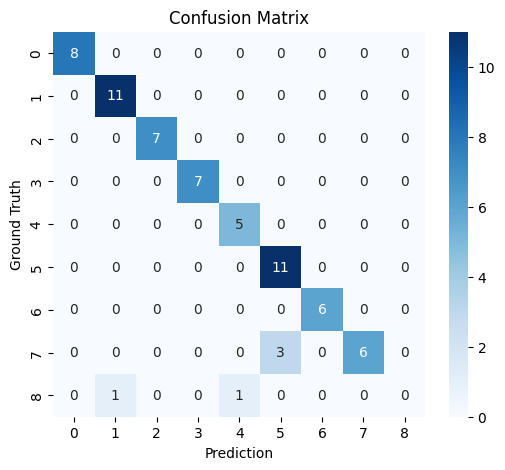

In [22]:
confusion_mat = confusion_matrix(true_vals, np.argmax(predictions, axis=1), labels=np.arange(9))
confusion_df  = pd.DataFrame(confusion_mat, index=np.arange(9), columns=np.arange(9))

plt.figure(figsize=(6, 5))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues", xticklabels=range(9), yticklabels=range(9))
plt.ylabel('Ground Truth')
plt.xlabel('Prediction')
plt.title('Confusion Matrix')
plt.show()

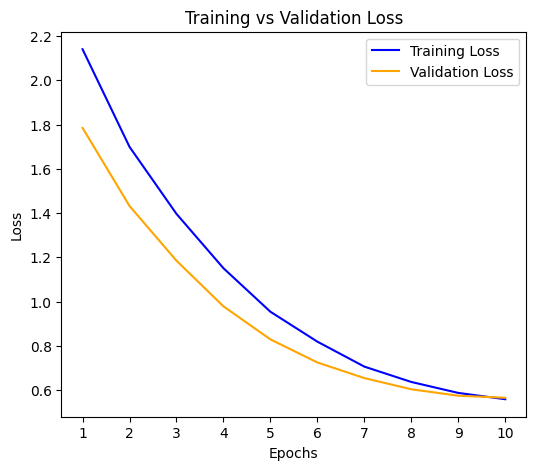

In [23]:
plt.figure(figsize=(6, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss', color='blue')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss', color='orange')
plt.xticks(range(1, epochs + 1))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()